# Training a skip-gram (word2vec) model on a small TED talk corpus

### Prerequisites: pandas, gensim, nltk, plotnine, and UMAP

In [1]:
import pandas as pd
from umap import UMAP
from plotnine import *
from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec

### Load in the data using pandas.

Each row corresponds to one observation, roughly a sentence long.

There are three columns to the data: 

* file_id (which talk it comes from)
* chunk_id (which segment of the file)
* chunk_text (a short utterance)

In [2]:
df = pd.read_csv('../ted_en-20160408_full.txt', sep="\t")
print(df.sort_values(['file_id', 'chunk_id']).head())

   Unnamed: 0  file_id  chunk_id  \
0           0        1         0   
1           1        1         1   
2           2        1         2   
3           3        1         3   
4           4        1         4   

                                          chunk_text  
0               Here are two reasons companies fail:  
1                     they only do more of the same,  
2                        or they only do what's new.  
3    To me the real, real solution to quality growth  
4  is figuring out the balance between two activi...  


### Implementing word2vec for a standard corpus of English requires a few components:

1. Make sure your text is broken into words
2. Determine whether you want your text lowercase or not (to treat THIS, ThiS, and thiS as equals)
3. Select a few major parameters:
    * Do you want skip-gram or continuous bag-of-words (CBOW)? (`sg`)
    * What amount of context do you want to consider to "define" a word? (`window`)
    * How many "negative" words do you want the model to use during training? (`negative`)
    
I defined these values below to use _skip-gram_ with a context window of 5 words to each side, and 5 negative words.

In [3]:
model_type = 1    # skip-gram
window_size = 3
negative_size = 5
n_dims = 100

w2v_model = Word2Vec([word_tokenize(x.lower()) for x in df['chunk_text'].values],
                     sg=model_type, window=window_size, negative=negative_size, size=n_dims)

### Inspecting the learned representations

0. Store the vectors in an easy-to-view format (e.g. a data frame)
1. Make sure the representations make sense -- e.g. simple tests with common words
2. Visualize it

In [4]:
vector_df = pd.DataFrame(w2v_model.wv.vectors,
                         index=list(w2v_model.wv.vocab.keys()))

In [5]:
w2v_model.wv.most_similar('red')

[('blue', 0.8355171084403992),
 ('yellow', 0.8312761783599854),
 ('pale', 0.7892845869064331),
 ('orange', 0.7883366346359253),
 ('purple', 0.7469253540039062),
 ('dotted', 0.7429549098014832),
 ('gray', 0.7304237484931946),
 ('bars', 0.7162660956382751),
 ('green', 0.7161343097686768),
 ('fluorescent', 0.7153248190879822)]

## Visualization

There are a number of choices we could make here (t-SNE, UMAP, hierarchical clustering). It is common to use t-SNE for visualization but it can be slow. Instead, we will use UMAP. Typically the results are comparable.

In [6]:
umap = UMAP()
umap_vectors = umap.fit_transform(vector_df)
umap_df = pd.DataFrame(umap_vectors, index=vector_df.index.values, columns=['umap_x', 'umap_y'])

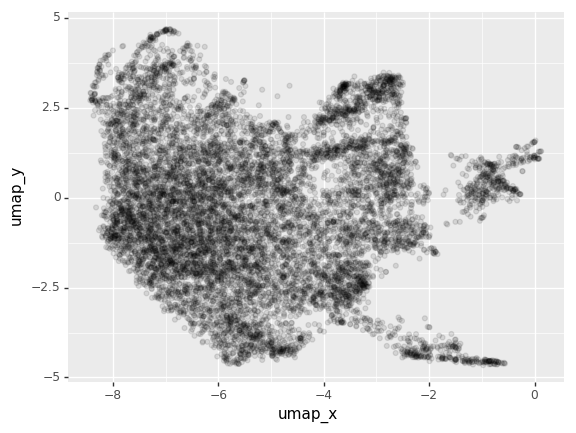

<ggplot: (-9223372036535283140)>

In [7]:
ggplot(umap_df.sample(frac=0.5), aes('umap_x', 'umap_y')) + geom_point(alpha=0.1)

## Save the model for later reuse

If you want to get it back, simply load it in the same way you saved it:

```
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("w2v.model")
```

In [8]:
w2v_model.save('./w2v.model')